# CS345 Final Project Report
## Introduction
### Dataset

The dataset used for this project is from a posting from [kaggle.com](https://kaggle.com) called [Predicting Credit Card Customer Segmentation](https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data) which sources an upload to [zendoo.org](https://zenodo.org) by a user named *zhyli* under the *Creative Commons Attribution 4.0 International* license. Here is the APA citation:

*zhyli. (2020). Prediction of Churning Credit Card Customers [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4322342*

This dataset contains many features that are both personal and financial, our usecase is to use personal features to make finanical classifications. Here are the personal features that are important to for our experiments, their data type and what they mean.

- `Attrition_Flag`: *boolean* - (`'Existing Customer'`/`'Attrited Customer'`) A boolean value representing if an entry is currently a customer or used to be a customer in the past.
- `Customer_Age`: *integer* - The age of the customer in years.
- `Gender`: *boolean* - (`M`/`F`) The gender of the customer.
- `Dependant_Count`: *integer* - The number of dependants that the customer has (Ex. child, partner, elderly parent).
- `Education_Level`: *categorical* - The highest education level that the customer has achieved which can include `'Uneducated'`, `'High School'`, `'College'`, `'Graduate'` or `'Unknown'`. 
- `Marital_Status`: *categorical* - The marital status of the customer which can include `'Single'`, `'Married'` or `'Unknown'` which is the reason this feature is not boolean.
- `Income_Category`: *categorical* - The range of income that the customer falls into based upon their annual income which ranges from `'Less than $40k'`, `'$40k - $60k'`, `'$60k - $80k'`, `'$80k - $120k'`, or `'Unknown'`.
- `Total_Relationship_Count`: *integer* - The number of relationships that the customer has with the credit card provider (Ex. Savings account, Checking account, Mortgage, Credit card accounts). 

Here is the financial feature that we are trying to make classifications about.

- `Credit_Limit`: *integer* - The total amount of money a customer is allowed to borrow on a credit card.

Because this features is an integer, we transform it into categorical data which is explained in the [Creating Variable Classifications](#Creating-Variable-Classifications) section of this notebook.

These personal features are important to us because our hypothesis is that there is a correlation between strictly personal data and strictly financial data. In other words, the credit limit of an individual **is not independant of every personal feature**. These are all the personable features that the dataset contains and we wish to find the features with the highest correlation to the credit limit of an entry.

## Data Loading and Formatting

Before we do anything, we need to load the credit card customer data properly. The `load_credit_card_customer_data` checks to see if the data file `BankChurners.csv` has already been downloaded and if not, it downloads it from `zenodo.org`. Initially we had this function return an `X, y` but it returns a `pandas` dataframe. This is because it's easier to index a `pandas` with the columns that we want to select, this functionality is present in `select_features`. We then select personal features that we want to use as information to predict a financial feature.

In [96]:
import os
import requests
import pandas as pd
import numpy as np

def load_credit_card_customer_data(X_features, y_label):
    filename = "BankChurners.csv"
    if not os.path.exists(filename):
        url = "https://zenodo.org/records/4322342/files/BankChurners.csv?download=1"
        response = requests.get(url)
        with open(filename, "wb") as f:
            f.write(response.content)

    data = pd.read_csv(filename)
    X = data[X_features].values
    y = data[y_label].values
    return data, X, y

# dict used later on for cleaner indexing
personal_features = {
    'Attrition_Flag': 0,
    'Customer_Age': 1,
    'Gender': 2,
    'Dependent_count': 3,
    'Education_Level': 4,
    'Marital_Status': 5,
    'Income_Category': 6,
    'Total_Relationship_Count': 7
}

labels_column = 'Credit_Limit'
personal_features_headers = list(personal_features.keys())

data, X, y = load_credit_card_customer_data(personal_features_headers, labels_column)
X.shape, y.shape

((10127, 8), (10127,))

Here we can see that we have the `8` personal features and `1` label column. Also there is `10127` rows in this dataset which is pretty big. However, we can see that some of the columns contain categorical data. For example, the `'Attrition_Flag'` will contain either `'Existing Customer'` or `'Attrited Customer'` and the `'Gender'` column will only include `'M'` or `'F'` and so on with `'Education_Level'`, `'Marital_Status'` and `'Income_Category'`.

In [97]:
pd.DataFrame(X[:5, :], columns=personal_features)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Total_Relationship_Count
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,5
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,6
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,4
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,3
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,5


To fix this we need to transform this categorical data into numerical data.

### Transforming Categorical Data to Numerical Data

Classifiers like `SVM` can only interpret numerical data and not strings like `"Existing Customer"`. So we need to |convert these categorical features to binary categorical data using `OneHotEncoder`. This will create $n$ columns for $n$ different categories in the categorical column and label the entries with either $1$ or $0$ depending on if the entry is in that category. The reason that we don't just assign each category an integer is because we don't want there to be an *order* associated with a column and boolean columns achieve this by only assigning `1` or `0`.

In [98]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(col):
    encoder = OneHotEncoder(sparse_output=False) # sparse_output=False returns a regular numpy array which is needed for hstack
    arr = encoder.fit_transform(col.reshape(-1, 1)) # reshape for hstack
    headers = encoder.categories_[0].tolist() # get the respective categories that have been created
    return headers, arr

boolean_cols = ["Attrition_Flag", "Gender"]
integer_cols  = ["Customer_Age", "Dependent_count", "Total_Relationship_Count"]
categorical_cols = ["Education_Level", "Marital_Status", "Income_Category"]

X_numerical_parts = []
header_parts = []

for col_name in boolean_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    first_value = col[0] # The first entry's value is going to be represented by 1
    binary_col = np.where(col == first_value, 1, 0)
    X_numerical_parts.append(binary_col.reshape(-1, 1)) # reshape for hstack
    header_parts.append(f"{first_value}=1")

for col_name in integer_cols:
    idx = personal_features[col_name]
    col = X[:, idx].reshape(-1, 1) # reshape for hstack
    X_numerical_parts.append(col)
    header_parts.append(col_name)

for col_name in categorical_cols:
    idx = personal_features[col_name]
    col = X[:, idx]
    names, arr = one_hot_encode(col)
    X_numerical_parts.append(arr)
    header_parts.extend(names)

X_numerical = np.hstack(X_numerical_parts)

# dict for cleaner indexing later on
headers = { header: i for i, header in enumerate(header_parts) }

pd.DataFrame(X_numerical[:5, :], columns=header_parts)

,Existing Customer=1,M=1,Customer_Age,Dependent_count,Total_Relationship_Count,College,Doctorate,Graduate,High School,Post-Graduate,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,1,1,45,3,5,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,49,5,6,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,51,3,4,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,40,4,3,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,40,3,5,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we have completely numerical data, we can see that each category has its own binary column. We also have increased the number of columns from `8` to `22` because each category gets its own column.

In [99]:
X_numerical.shape

(10127, 22)

## Creating Variable Classifications

The last data formatting step we need to perform is the categorizaion of the `'Credit_Limit'`. For a binary classification, we will classify a customer based on if their credit limit is higher than the median or lower than the median. 

Later on, we will create more categories in order to compare the accuracy of a model based upon the number of different classifications it can make **on the same data**. We can take variable $g$ which represents the number of different classifications. When $g = 2$ we are classifying if a customer has a credit limit higher than the median, or a credit limit lower than the median. When $g = 3$ we are classifying if a customer is in the bottom 33rd percentile, in the middle 33rd percentile, or in the top 33rd percentile in terms of credit limit. This is part of our experimentation as this is an idea we had in order to measure the accuracy of models based the number of classification they could make **on the same data**.

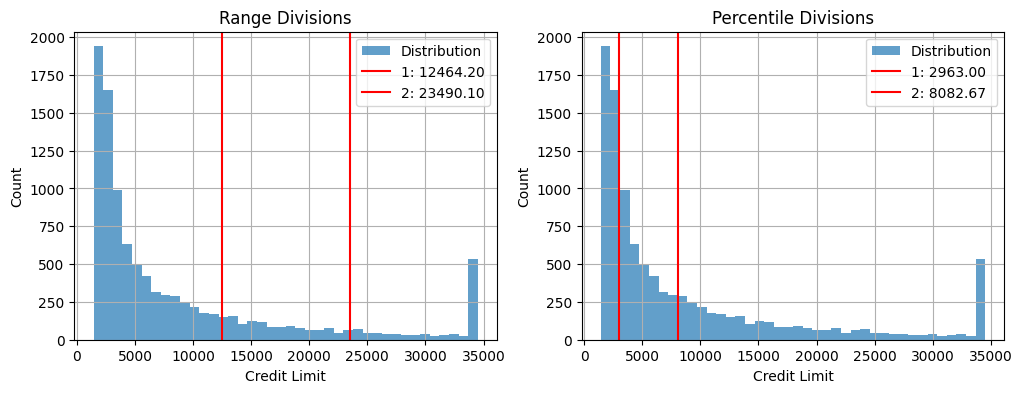

In [100]:
import matplotlib.pyplot as plt

def plot_divisions(ax, y, divisions, title=""):
    ax.hist(y, bins=40, alpha=0.7, label="Distribution")

    for i, division in enumerate(divisions):
        ax.axvline(division, color='red', label=f"{i+1}: {division:.2f}")

    ax.set_title(title)
    ax.set_xlabel("Credit Limit")
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.legend()

def make_division(y, divisions):
    y = np.array(y)
    divisions = np.array(divisions)
    labels = np.zeros(len(y), dtype=int)
    
    for i, d in enumerate(divisions):
        labels[y > d] = i + 1
    return labels

def divide_percentile(g, y):
    chunk_size = 100 / g
    divisions = []
    for i in range(1, g): # start at 1 because we don't want to divide at the 0th percentile
        percentile = np.percentile(y, chunk_size * i)
        divisions.append(percentile)
    return divisions

def divide_range(g, y):
    y_min = min(y)
    y_max = max(y)
    step = (y_max - y_min) / g

    divisions = []
    for i in range(1, g):
        divisions.append(y_min + i * step)

    return divisions

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
divisions_range = divide_range(3, y)
plot_divisions(axes[0], y, divisions_range, title="Range Divisions")

divisions_percentile = divide_percentile(3, y)
plot_divisions(axes[1], y, divisions_percentile, title="Percentile Divisions")
plt.show()

These two histograms show the quantity of entries based upon a range of their credit limit, shown with the blue distrobution. They differ in the divisions that they make which will be used to classify the entries. The "*Range Divisions*" graph divides the entries based upon the range of the credit limit itself, we take the credit limit range and divide it into $g$ equal chunks such that the range in each chunk is equal. In the "*Percentile Divisions*" we make divisions based upon **the quantity of entries**, this means that there is an equal number of entries in each chunk. 

These graphs help visualize the divisions. The "*Range Divisions*" graph has equal thirds on the credit limit axis, and the "*Percentile Divisions*" graph has smaller divisions where there is a larger quantity of entries. The question that we are going to discuss later on is "*Does some model perform better on data labeled with an equal **amount of entries** in each classification, or does it perform better on data labeled with an equal **range of labels**?*" (`divide_percentile` or `divide_range`).

For now we are going to use the binary classification using `divide_percentile(2, y)` in order to classify entries if they are higher or lower than the median, but later on we will discuss the performance of models based upon which method we are using to label the data.

In [101]:
y_median = np.median(y)
print(f"y median: {y_median}")

# binary classification, half above the median, half below the median
divisions = divide_percentile(2, y)
y_median = make_division(y, divisions)

pd.DataFrame([y[:5], y_median[:5]], index=["y", "y_median"])

y median: 4549.0


,0,1,2,3,4
y,12691.0,8256.0,3418.0,3313.0,4716.0
y_median,1.0,1.0,0.0,0.0,1.0


## Standardized vs Unstandardized Data

Our data has many columns that are either `1` or `0` because they were either *boolean* or *categorical*. The *integer* columns (`'Customer_Age'`, `'Dependent_count'`, and `'Total_Relationship_Count'`) are going unfairly outweigh all of the boolean columns because they all contain values larger than `1`. For example the `'Gender'` columns is going to have either a `1` or a `0` and the `'Customer_Age'` column ranges from `26` to `73` which is going to unfairly outweigh the `'Gender'` column and all other *boolean* columns.

To fix this we need to standardize the data in a way that equally considers both *boolean* and *integer* columns. 

The formula that we are using to standardize the data is:

$$
z = \frac{x - \mu}{\sigma}
$$

Where $z$ is the z-score or the standardized value of an entry, $x$ is the original value of the entry, $\mu$ is the average across all entries, and $\sigma$ is the standard deviation across all entries. This function does two things to standardize the data, first is that it centers the mean of the entries at 0 with $x - \mu$ and second, it makes the variance of the data equal to one with $\frac{1}{\sigma}$. This way all the standardized data is centered around 0 and has an equal variance. This ensures that we are considering each feature equally in the data and we don't have any features that are outweighing others based on scale alone.

In [102]:
def standardize_col(col):
    col_mean = np.mean(col)
    col_std = np.std(col)
    if col_std == 0:
        col_std = 1
    return (col - col_mean) / col_std

X_standardized = X_numerical.copy()

for col_name in integer_cols:
    idx = headers[col_name]
    X_standardized[:, idx] = standardize_col(X_standardized[:, idx])

pd.DataFrame(X_standardized[:5], columns=header_parts)

,Existing Customer=1,M=1,Customer_Age,Dependent_count,Total_Relationship_Count,College,Doctorate,Graduate,High School,Post-Graduate,...,Divorced,Married,Single,Unknown,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
0,1,1,-0.165406,0.503368,0.763943,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,0.33357,2.043199,1.407306,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,0.583058,0.503368,0.120579,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,0,-0.789126,1.273283,-0.522785,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,-0.789126,0.503368,0.763943,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In order to accurately test if our standardization is actually improving the quality of data, we are going to gather accuracies of unstandardized data and standandardized data using KNN. We will then iterate over different values of the hyperparameter `k` in order to see what the highest accuracy each dataset can achieve **using the same model**. 

In order to accurately test our classifier with different hyperparameters, we need to **cross validate** the results from our training data with testing data. This is important because we don't want to overfit to out training data and falsely report a high accuracy. To cross validate the results from KNN we are going to use sklearn's `StratifiedKFold`. `StratifiedKFold` repeatedly splits the data into training and testing datasets such that each fraction of the entries labeled one way is equally represented in both the training and test sets with the same fractions. This is important because we have an equal percentage of classification partitions in the training and test sets to the data set as a whole. This simulates a real world scenerio where we need to train the model on data collected and make classifications based on unseen data. 

The `n_splits` value is the number of splits that we are going to be making with this cross validator. For instance if `n_splits=5`, we are going to divide the data into 5 parts and use a different fifth as the test data every iteration. These splits also ensure that we are keeping the same fraction of classifications across each split. In our case, we are splitting the data by the media which means that 50% of the data is in each classification. So our training and testing data are also going to contain 50% of each classification. 

The `shuffle=True` means that we are shuffling the data which is important because there might be some skewness in the way that the data is input into our dataset. We don't know how this data was collected, so we are going to shuffle the data just to be safe.

We then use the cross validator provided by `StratifiedKFold` to cross validate the training of the model with the training data against the classifications made with the testing data. We input our sklearn style classifier (`KNeighborsClassifier`), our feature matrix (`X`), our labels (`y`) and lastly our cross validator (`StratifiedKFold`) which runs 5 times (because `n_split=5`) and gathers the accuracy of each run (because `scoring="accuracy"`). 

We then take the average of these accuracies and plot them along the different values of the hyperparameter `k`.

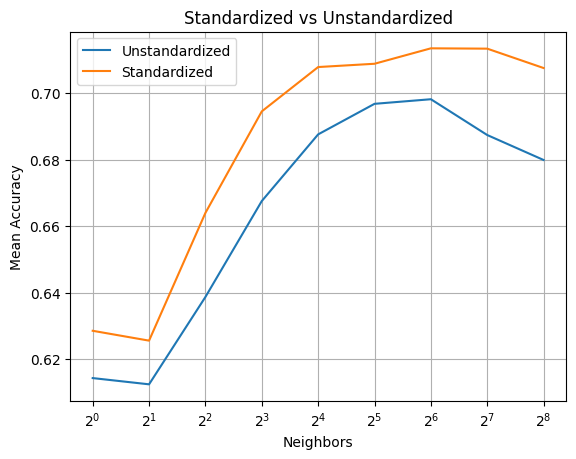

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_knn_accuracies(X, y, k_values):
    accuracies = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for k in k_values:
        classifier = KNeighborsClassifier(k)
        scores = cross_val_score(classifier, X, y, cv=cv, scoring="accuracy")
        accuracies.append(np.mean(scores))
    return accuracies

k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
unstandardized_accuracies = get_knn_accuracies(X_numerical, y_median, k_values)
standardized_accuracies = get_knn_accuracies(X_standardized, y_median, k_values)

plt.plot(k_values, unstandardized_accuracies, label="Unstandardized")
plt.plot(k_values, standardized_accuracies, label="Standardized")

plt.xscale('log', base=2)
plt.xlabel("Neighbors")
plt.ylabel("Mean Accuracy")
plt.title("Standardized vs Unstandardized")
plt.grid(True)
plt.legend()
plt.show()

We can then see that KNN performs better using the standardized data than the unstandardized data. The standardized data doesn't have the *integer* columns outweighing all the other *boolean* columns and can equally consider each feature for the classification. It's also interesting that the accuracy of the model using the standardized data peaks at `k=64` and the accuracy of the model using the unstandardized data peaks at `k=32`. 

Our hypothesis is that the *integer* columns in the unstandardized data have greater values on average than the *boolean* columns which leads to a skewed distance calculation when finding the nearest neighbors to an entry from the test set. When calculating the distance between two points, the unstandardized integer column is going to provide over inflated distance measurements because the majority of the data is contains *boolean* values.

For instance, suppose we are only considering the `'Gender'` and `'Customer_Age'` columns of two entries. Let's say entry one has `1, 34` and entry two has `0, 40` with the columns being `'Gender'` and `'Customer_Age'` respectively. These entries differ in `'Gender'` by `1` and differ in `'Customer_Age'` by `6` which means that when we measure the distance between these two points, they are going to seem farther apart because of the **type and range of data** in `'Customer_Age'` when we should actually be considering `'Gender'` and `'Customer_Age'`. This causes inaccuracies in our data which leads to a lower average accuracy for unstandardized data.

Standardized data performs better because we now have a more similar range of data to the *boolean* columns as our integer columns have been centered around 0 and have a variance of 1.

### Maybe order is good?



In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_standardized, y_median)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

Best score: 0.7220367323559163
Best params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
